In [1]:
from scipy.io import wavfile
from scipy.signal import spectrogram
import matplotlib.pyplot as plt
from librosa.feature import melspectrogram
from librosa import frames_to_time

import librosa
import numpy as np
from whisper.audio import load_audio, log_mel_spectrogram
import torch

In [15]:
raw = wavfile.read("original_audio.wav")
attack = wavfile.read("audio_with_attack.wav")
my_noise = np.load("/home/jaydenfassett/audioversarial/imperceptible/noise/raw_audio/overlay/discriminator/noise_100tsteps.np.npy")
# fnoise_mel = torch.load("/home/jaydenfassett/audioversarial/imperceptible/noise/prepend/noise.pth",weights_only=True)
# their_mel = torch.load("/home/jaydenfassett/audioversarial/imperceptible/demotest/rainamel.th",weights_only=True)['softprompt'].unsqueeze(0)
# overlay_mel = torch.load("/home/jaydenfassett/audioversarial/imperceptible/noise/overlay/noise.pth")


def visualize(audio, ret=False):
    fs, aud = audio
    # aud = aud.astype(np.float32)


    mel_spectrogram_db = log_mel_spectrogram(aud).numpy()
    print(mel_spectrogram_db.shape)
    f, t_spec, Sxx = spectrogram(aud, fs=fs)

    fig, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].plot(aud)
    axes[0].set_title("Raw Audio")
    tick_positions = axes[0].get_xticks()
    tick_positions = tick_positions[tick_positions >= 0]
    axes[0].set_xticks(tick_positions)
    axes[0].set_xticklabels([f"{tick / fs:.1f}" for tick in tick_positions])

    axes[1].pcolormesh(t_spec, f, 10 * np.log10(Sxx), shading='gouraud')
    axes[1].set_title("Spectrogram")
    axes[1].set_xlabel("Time (s)")

    librosa.display.specshow(mel_spectrogram_db, sr=fs, hop_length=160, 
                             x_axis='time', y_axis='mel', ax=axes[2],shading="gouraud",cmap="magma")
    axes[2].set_title("Mel Spectrogram")
    axes[2].set_ylabel("Mel Frequency")
    axes[2].set_xlabel("Time (s)")

    plt.tight_layout()
    plt.show()

    if ret:
        return audio, (f, t_spec, Sxx), mel_spectrogram_db


def contrast(aud1,aud2):

    fs1, aud1 = aud1
    fs2, aud2 = aud2
    aud1 = aud1.astype(np.float32)
    aud2 = aud2.astype(np.float32)

    hop_length = 160
    mel_spec1 = log_mel_spectrogram(aud1).numpy()
    mel_spec2 = log_mel_spectrogram(aud2).numpy()
    # mel_spectrogram1 = librosa.feature.melspectrogram(y=aud1, sr=fs1, n_mels=80, hop_length=hop_length)
    # mel_spectrogram_db1 = librosa.power_to_db(mel_spectrogram1, ref=np.max)

    # mel_spectrogram2 = librosa.feature.melspectrogram(y=aud2, sr=fs1, n_mels=80, hop_length=hop_length)
    # mel_spectrogram_db2 = librosa.power_to_db(mel_spectrogram2, ref=np.max)

    fig,axes = plt.subplots(1,2,figsize = (12,5))

    librosa.display.specshow(mel_spec1, sr=fs1, hop_length=hop_length, 
                            x_axis='time', y_axis='mel', ax=axes[0],shading="gouraud",cmap="magma")
    
    librosa.display.specshow(mel_spec2, sr=fs2, hop_length=hop_length, 
                            x_axis='time', y_axis='mel', ax=axes[1],shading="gouraud",cmap="magma")
    axes[0].set_title(f"Unperturbed Audio ({len(aud1)/fs1:.2f} seconds)")
    axes[1].set_title(f"Perturbed Audio ({len(aud2)/fs2:.2f} seconds)")
# visualize(raw)


def contrast_mel_prepend(aud,mel):

    fs1, aud1 = aud
    aud1 = aud1.astype(np.float32)
    mel = mel.detach()

    hop_length = 160
    mel_spec1 = log_mel_spectrogram(aud1).unsqueeze(0)
    print(mel_spec1.shape,mel.shape)
    mel_spec2 = torch.cat([mel,mel_spec1],dim=-1).numpy().squeeze()
    mel_spec1 = mel_spec1.numpy().squeeze()
    print(mel_spec2.shape)
    # mel_spectrogram1 = librosa.feature.melspectrogram(y=aud1, sr=fs1, n_mels=80, hop_length=hop_length)
    # mel_spectrogram_db1 = librosa.power_to_db(mel_spectrogram1, ref=np.max)

    # mel_spectrogram2 = librosa.feature.melspectrogram(y=aud2, sr=fs1, n_mels=80, hop_length=hop_length)
    # mel_spectrogram_db2 = librosa.power_to_db(mel_spectrogram2, ref=np.max)

    fig,axes = plt.subplots(1,2,figsize = (12,5))

    vmin = min(mel_spec1.min(), mel_spec2.min())
    vmax = max(mel_spec1.max(), mel_spec2.max())

    img1 = librosa.display.specshow(mel_spec1, sr=fs1, hop_length=hop_length, 
                            x_axis='time', y_axis='mel', ax=axes[0],shading="gouraud",cmap="magma")
    
    img2 = librosa.display.specshow(mel_spec2, sr=fs1, hop_length=hop_length, 
                            x_axis='time', y_axis='mel', ax=axes[1],shading="gouraud",cmap="magma",vmin=-1,vmax=1)
    

    fig.colorbar(img1, ax=axes[0], format='%+2.0f dB')
    fig.colorbar(img2, ax=axes[1], format='%+2.0f dB')
    axes[0].set_title(f"Unperturbed Audio ({len(aud1)/fs1:.2f} seconds)")
    axes[1].set_title(f"Perturbed Audio ({mel_spec2.shape[-1]/100:.2f} seconds)")
    plt.colorbar(label='Intensity (dB)')



def contrast_mels_prepend(aud,mel1,mel2):

    fs1, aud1 = aud
    aud1 = aud1.astype(np.float32)
    mel1 = mel1.detach().cpu()
    mel2 = mel2.detach().cpu()


    hop_length = 160
    aud_spec = log_mel_spectrogram(aud1).unsqueeze(0)


    mel_spec1 = torch.cat([mel1,aud_spec],dim=-1).numpy().squeeze()
    mel_spec2 = torch.cat([mel2,aud_spec],dim=-1).numpy().squeeze()

    mel_spec1 = mel_spec1.squeeze()
    mel_spec2 = mel_spec2.squeeze()

    # mel_spectrogram1 = librosa.feature.melspectrogram(y=aud1, sr=fs1, n_mels=80, hop_length=hop_length)
    # mel_spectrogram_db1 = librosa.power_to_db(mel_spectrogram1, ref=np.max)

    # mel_spectrogram2 = librosa.feature.melspectrogram(y=aud2, sr=fs1, n_mels=80, hop_length=hop_length)
    # mel_spectrogram_db2 = librosa.power_to_db(mel_spectrogram2, ref=np.max)

    fig,axes = plt.subplots(1,2,figsize = (12,5))

    vmin = min(mel_spec1.min(), mel_spec2.min())
    vmax = max(mel_spec1.max(), mel_spec2.max())

    img1 = librosa.display.specshow(mel_spec1, sr=fs1, hop_length=hop_length, 
                            x_axis='time', y_axis='mel', ax=axes[0],shading="gouraud",cmap="magma",vmin=-1,vmax=1)
    
    img2 = librosa.display.specshow(mel_spec2, sr=fs1, hop_length=hop_length, 
                            x_axis='time', y_axis='mel', ax=axes[1],shading="gouraud",cmap="magma",vmin=-1,vmax=1)
    

    fig.colorbar(img1, ax=axes[0], format='%+2.0f dB')
    fig.colorbar(img2, ax=axes[1], format='%+2.0f dB')
    axes[0].set_title(f"Attack 1 ({len(aud1)/fs1:.2f} seconds)")
    axes[1].set_title(f"Attack 2 ({mel_spec2.shape[-1]/100:.2f} seconds)")
    plt.colorbar(label='Intensity (dB)')



# contrast_mel(raw,fnoise_mel)
# contrast_mel(raw,fnoise_mel)
# contrast_mels_prepend(raw,fnoise_mel,their_mel)

/tmp/ipykernel_3084896/1911026766.py:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  overlay_mel = torch.load("/home/jaydenfassett/audioversarial/imperceptible/noise/overl

Original Mel Spectrogram Min: -0.9000389575958252, Max: 1.0999610424041748
Noise Mel Spectrogram Min: -3.590121030807495, Max: 3.621640920639038


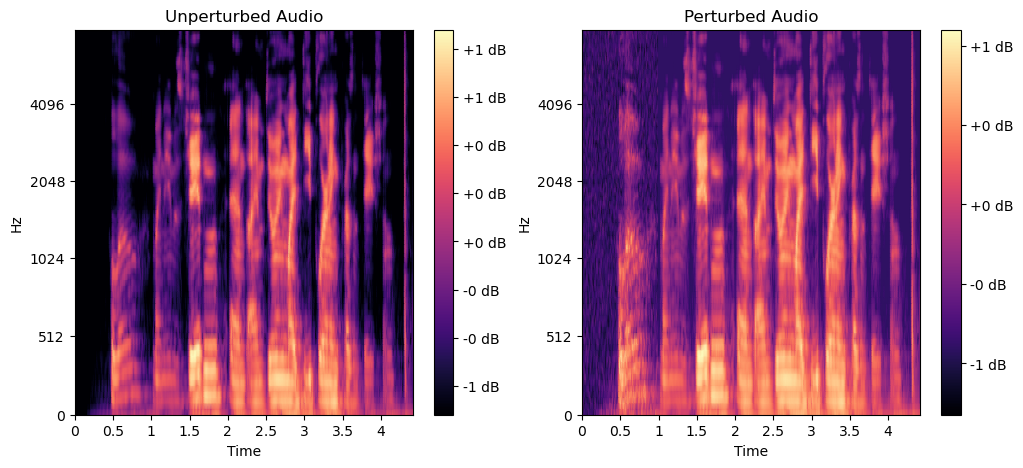

In [106]:
def contrast_mel_overlay(aud, mel, alpha=0.5):
    fs1, aud1 = aud
    aud1 = aud1.astype(np.float32)
    mel = mel.detach()

    hop_length = 160

    mel_spec1 = log_mel_spectrogram(aud1).unsqueeze(0)

    noise = mel.cpu().numpy().squeeze(0)

    noise_min = noise.min()
    noise_max = noise.max()
    noise_normalized = (noise - noise_min) / (noise_max - noise_min + 1e-8)

    mel_spec_min = mel_spec1.min().item()
    mel_spec_max = mel_spec1.max().item()

    noise_scaled = noise_normalized * (mel_spec_max - mel_spec_min) + mel_spec_min
    noise_scaled = alpha * noise_scaled

    if noise_scaled.shape[-1] < mel_spec1.shape[-1]:
        padding = np.zeros((mel_spec1.shape[1], mel_spec1.shape[2] - noise_scaled.shape[1]))
        noise_padded = np.concatenate((noise_scaled, padding), axis=-1)
    else:
        noise_padded = noise_scaled[:, :mel_spec1.shape[2]]

    mel_spec2 = mel_spec1.cpu().numpy().squeeze(0) + noise_padded
    mel_spec1_np = mel_spec1.cpu().numpy().squeeze(0)

    print(f"Original Mel Spectrogram Min: {mel_spec1_np.min()}, Max: {mel_spec1_np.max()}")
    print(f"Noise Mel Spectrogram Min: {mel.min().item()}, Max: {mel.max().item()}")

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    img1 = librosa.display.specshow(mel_spec1_np, sr=fs1, hop_length=hop_length,
                                    x_axis='time', y_axis='mel', ax=axes[0],
                                    shading="gouraud", cmap="magma")

    img2 = librosa.display.specshow(mel_spec2, sr=fs1, hop_length=hop_length,
                                    x_axis='time', y_axis='mel', ax=axes[1],
                                    shading="gouraud", cmap="magma")

    fig.colorbar(img1, ax=axes[0], format='%+2.0f dB')
    fig.colorbar(img2, ax=axes[1], format='%+2.0f dB')
    axes[0].set_title("Unperturbed Audio")
    axes[1].set_title("Perturbed Audio")
    plt.show()

overlay_mel = torch.load("/home/jaydenfassett/audioversarial/imperceptible/noise/overlay/noise.pth")

contrast_mel_overlay(raw,overlay_mel)
# contrast_mel_overlay(raw,their_mel.cpu())


In [11]:
# clipped = np.load("/home/jaydenfassett/audioversarial/prepend_acoustic_attack/fassett/clipped.np.npy")
# unclipped = np.load("/home/jaydenfassett/audioversarial/prepend_acoustic_attack/fassett/unclipped.np.npy")

# craw = (16000,np.concatenate((clipped,raw[1])))
# ucraw = (16000,np.concatenate((unclipped,raw[1])))

fakenoise = (16000,np.concatenate((my_noise.squeeze(),raw[1])))


In [21]:
fnoise = np.load("/home/jaydenfassett/audioversarial/imperceptible/noise/prepend/noise.np.npy")
fnoise_mel = torch.load("/home/jaydenfassett/audioversarial/imperceptible/noise/prepend/noise.pth",weights_only=True)
craw = (16000,np.concatenate((fnoise.squeeze(),raw[1])))


(80, 543)


/tmp/ipykernel_3625813/2343697070.py:27: RuntimeWarning: divide by zero encountered in log10
  axes[1].pcolormesh(t_spec, f, 10 * np.log10(Sxx), shading='gouraud')


RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

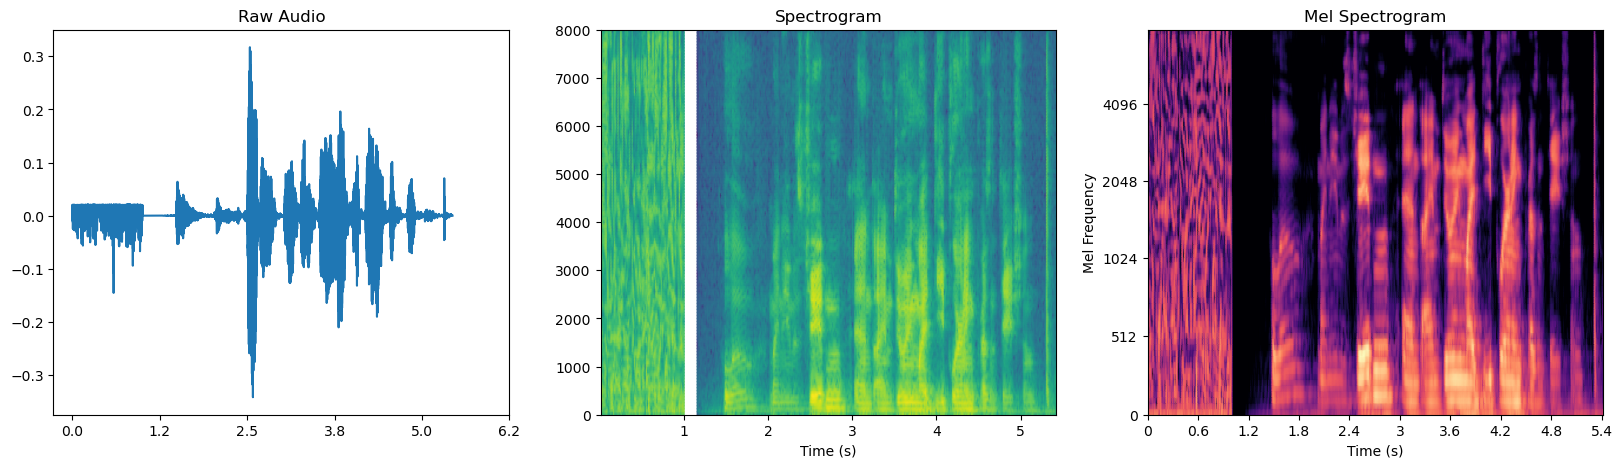

In [14]:
visualize(fakenoise)

In [11]:
import numpy as np

def describe(vector):
    vector = np.array(vector)
    stats = {
        "Count": len(vector),
        "Mean": np.mean(vector),
        "Median": np.median(vector),
        "Standard Deviation": np.std(vector),
        "Variance": np.var(vector),
        "Minimum": np.min(vector),
        "Maximum": np.max(vector),
        "Range": np.max(vector) - np.min(vector),
        "25th Percentile": np.percentile(vector, 25),
        "50th Percentile": np.percentile(vector, 50),
        "75th Percentile": np.percentile(vector, 75)
    }
    return stats


print(describe(fnoise.squeeze()))
print(describe(raw[1]))

{'Count': 15840, 'Mean': -0.00011869603, 'Median': -0.0056826044, 'Standard Deviation': 3.2775033, 'Variance': 10.742027, 'Minimum': -15.250326, 'Maximum': 13.075061, 'Range': 28.325386, '25th Percentile': -2.1898881793022156, '50th Percentile': -0.005682604620233178, '75th Percentile': 2.1893457770347595}
{'Count': 70997, 'Mean': 6.708563e-06, 'Median': 0.0, 'Standard Deviation': 0.027921867, 'Variance': 0.0007796307, 'Minimum': -0.3416748, 'Maximum': 0.31707764, 'Range': 0.65875244, '25th Percentile': -0.003662109375, '50th Percentile': 0.0, '75th Percentile': 0.004150390625}


(80, 506)


/tmp/ipykernel_3084896/1963793009.py:22: RuntimeWarning: divide by zero encountered in log10
  axes[1].pcolormesh(t_spec, f, 10 * np.log10(Sxx), shading='gouraud')


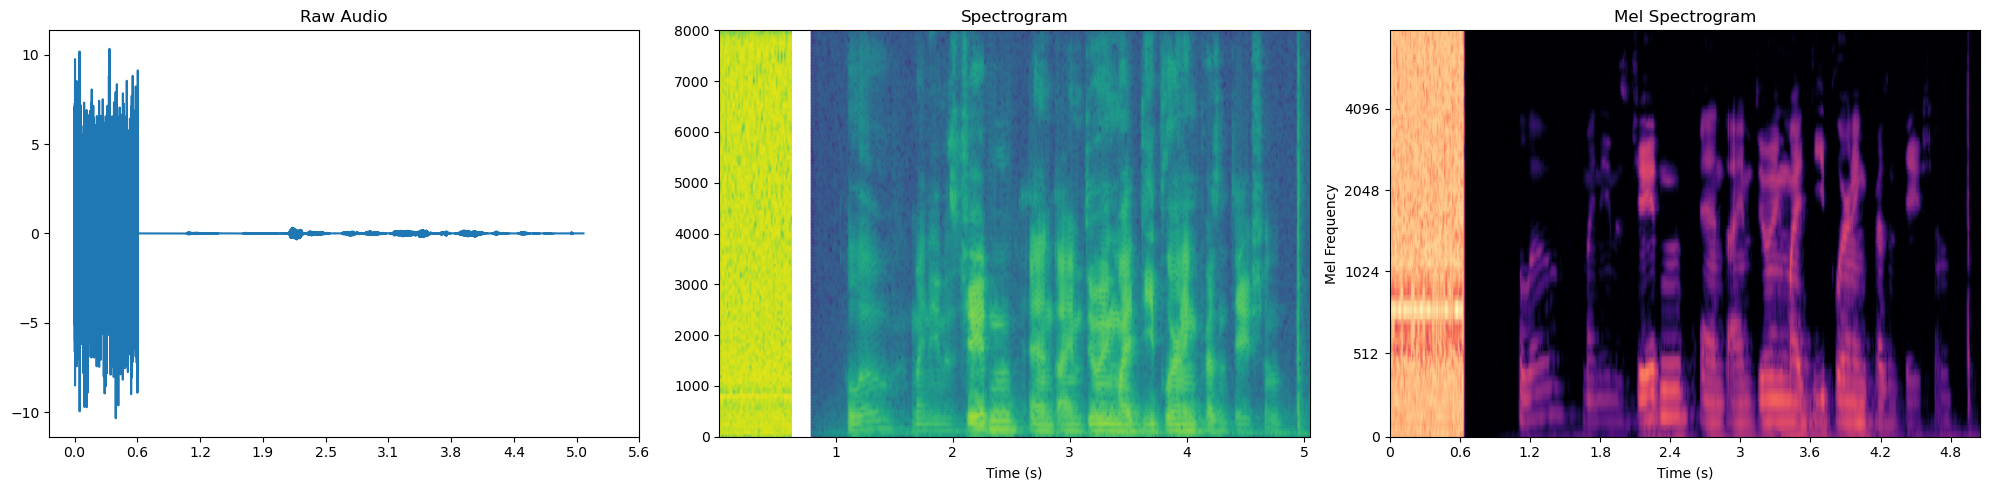

In [23]:
visualize(craw)

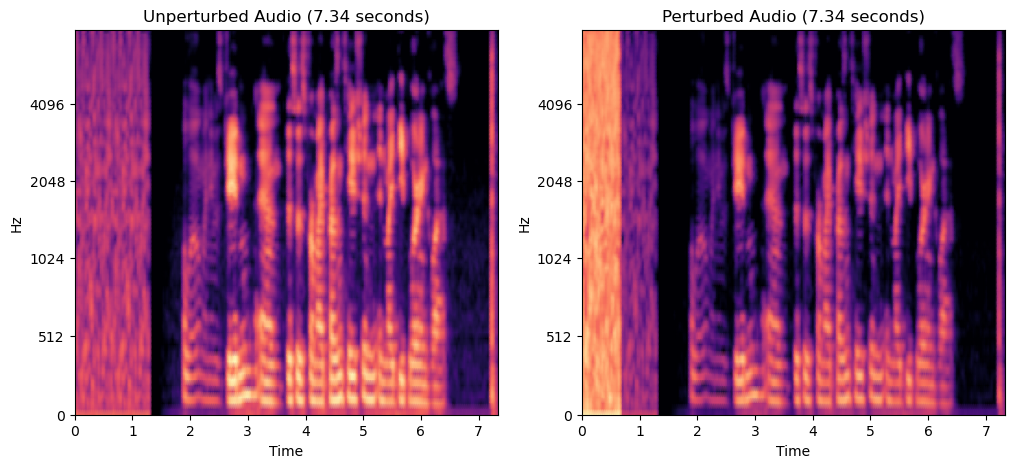

In [ ]:
contrast(craw,ucraw)

/tmp/ipykernel_3026875/2803842299.py:23: RuntimeWarning: divide by zero encountered in log10
  axes[1].pcolormesh(t_spec, f, 10 * np.log10(Sxx), shading='gouraud')


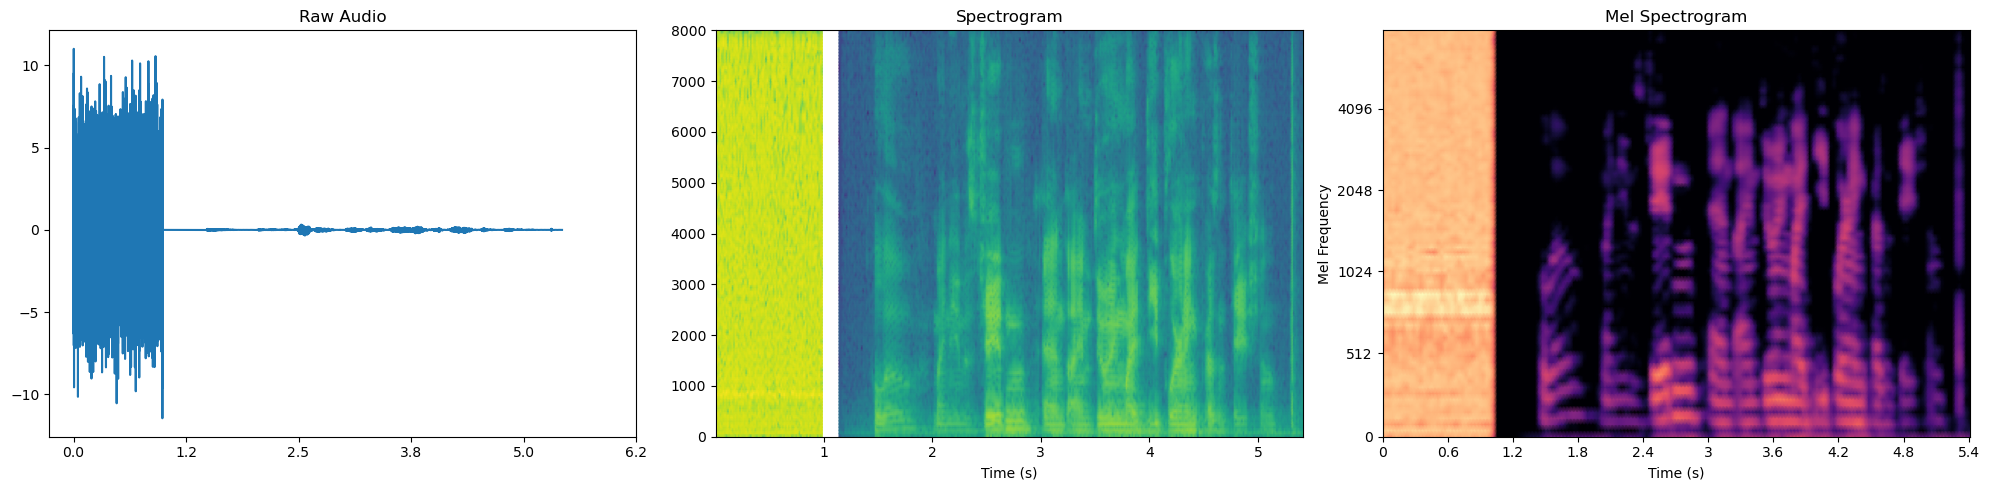

In [16]:
visualize(craw)

/tmp/ipykernel_1790817/1750790731.py:23: RuntimeWarning: divide by zero encountered in log10
  axes[1].pcolormesh(t_spec, f, 10 * np.log10(Sxx), shading='gouraud')


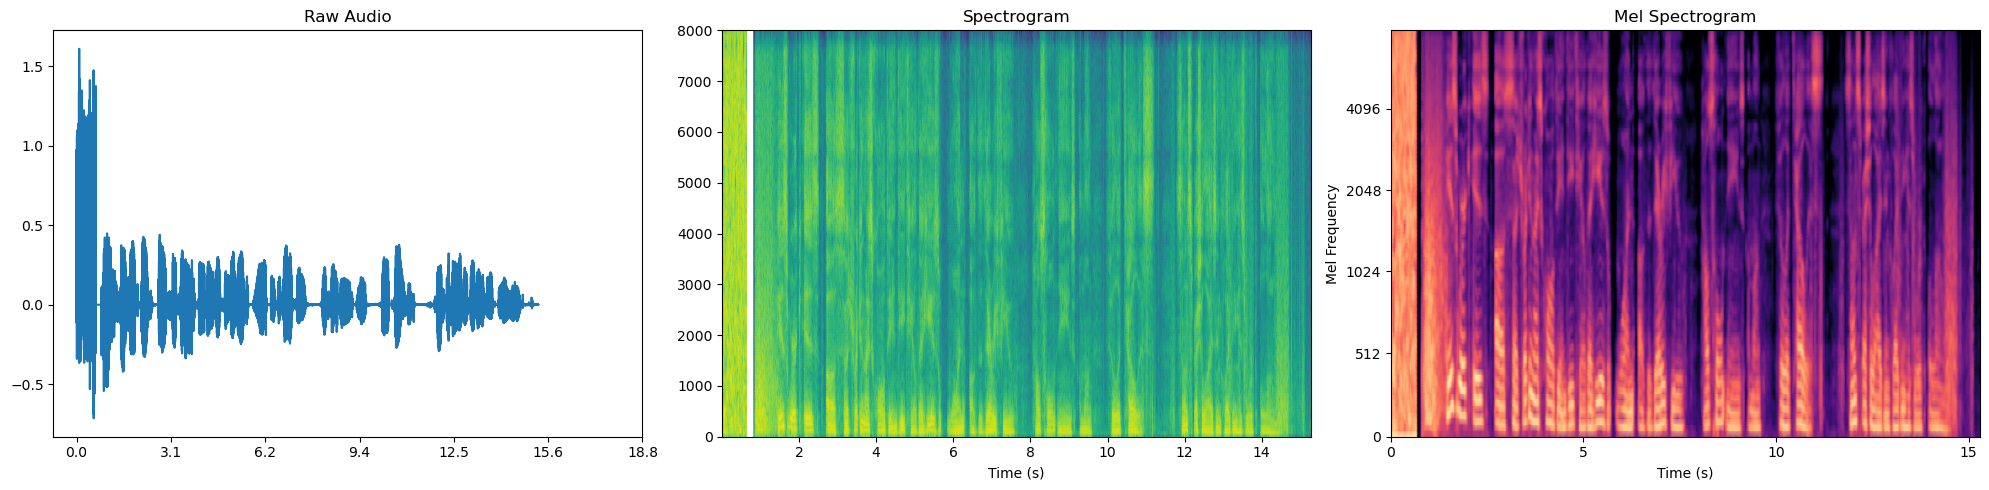

In [ ]:
visualize(ucraw)